In [83]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import cv2
import dlib
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

In [85]:
from utils import better_plotter
from utils import get_landmark_coords
from utils import crop_face_with_padding
from utils import resize_image_to_target_height
from utils import concat_images

In [86]:
# Initialize the face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('predictor/shape_predictor_68_face_landmarks.dat')

In [87]:
# Load the image
source_img = cv2.imread('images/vermeer.jpg')
target_img = cv2.imread('images/american-gothic.jpg')

## Extracting facial feature points

In [100]:
# Convert the image to grayscale
source_img_gray = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
target_img_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
source_faces = detector(source_img_gray)
target_faces = detector(target_img_gray)

print("number of faces in [source] is", len(source_faces))
print("number of faces in [traget] is", len(target_faces))

number of faces in [source] is 1
number of faces in [traget] is 2


source face coordinates: (463, 701) (998, 1236)
target face coordinates: (112, 211) (261, 360)


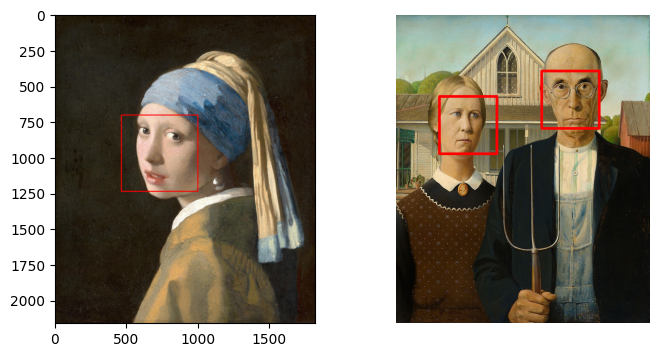

In [101]:
print(
    "source face coordinates:",
    (source_faces[0].left(), source_faces[0].top()), 
    (source_faces[0].right(), source_faces[0].bottom())
)

print(
    "target face coordinates:",
    (target_faces[0].left(), target_faces[0].top()), 
    (target_faces[0].right(), target_faces[0].bottom())
)

image_with_source_face = cv2.cvtColor(source_img.copy(), cv2.COLOR_BGR2RGB)
for i in range(len(source_faces)):
    cv2.rectangle(
        image_with_source_face, 
        (source_faces[i].left(), source_faces[i].top()), 
        (source_faces[i].right(), source_faces[i].bottom()),
        (255, 0, 0), 
        5
    )

image_with_target_face = cv2.cvtColor(target_img.copy(), cv2.COLOR_BGR2RGB)
for i in range(len(target_faces)):
    cv2.rectangle(
        image_with_target_face, 
        (target_faces[i].left(), target_faces[i].top()), 
        (target_faces[i].right(), target_faces[i].bottom()),
        (255, 0, 0), 
        5
    )

better_plotter([
    {
        "img": image_with_source_face,
        "title": ""
    },
    {
        "img": image_with_target_face,
        "title": ""
    }
], plot_size=(8, 4))

## Adjust the size of source face to the be similar size as the target face

Since our resulting image is based on the target image.

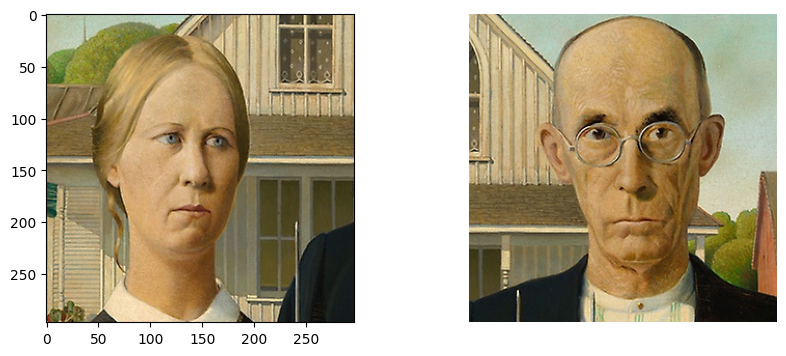

In [154]:
# source_face = crop_face_with_padding(
#     source_img, 
#     source_faces[0],
#     padding_ratio=1/2
# )

source_face = crop_face_with_padding(
    target_img, 
    target_faces[0],
    padding_ratio=1/2
)

target_face = crop_face_with_padding(
    target_img, 
    target_faces[1],
    padding_ratio=1/2
)

better_plotter([
    {
        "img": source_face,
        "title": ""
    },
    {
        "img": target_face,
        "title": ""
    }
], plot_size=(10, 4))

## Concate two faces

This solves the issue that, when triangulate with faces in two different images, we get different triangulation structure. 

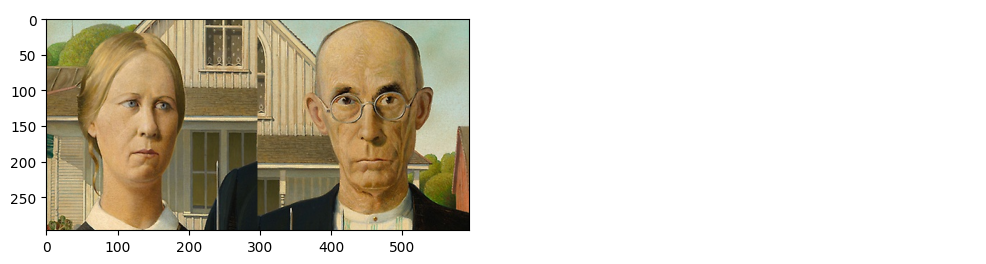

In [108]:
source_face_resized = resize_image_to_target_height(source_face, target_face)
concated_source_target = concat_images(source_face_resized, target_face)

better_plotter([
    {
        "img": concated_source_target,
        "title": ""
    }
], plot_size=(12, 3))

In [155]:
concated_gray = cv2.cvtColor(concated_source_target, cv2.COLOR_BGR2GRAY)
concated_faces = detector(concated_gray)

print("number of faces in [source] is", len(concated_faces))

number of faces in [source] is 2


## Start Triangulation

In [110]:
faces = concated_faces # source_faces
image_gray = concated_gray # source_img_gray
image = cv2.cvtColor(concated_source_target, cv2.COLOR_BGR2RGB)

face [(62, 62) (211, 211)] 	 number of landmarks: 68 	 number of triangles: 108
face [(377, 78) (526, 228)] 	 number of landmarks: 68 	 number of triangles: 108
source_triangles[0] [(388, 112), (410, 115), (390, 132)]
target_triangles[0] [(72, 126), (108, 120), (71, 143)]


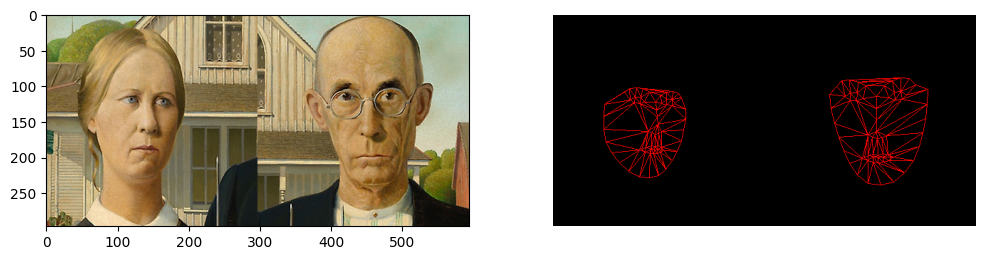

In [153]:
image_triangulation = cv2.cvtColor(np.zeros_like(image.copy()), cv2.COLOR_BGR2RGB)

# Get landmarks and perform Delaunay triangulation on the first face as a reference
if faces:
    reference_landmarks = predictor(image_gray, faces[0])
    reference_coords = get_landmark_coords(reference_landmarks)
    tri = Delaunay(reference_coords)

source_coords = []
target_coords = []

source_triangles = []
target_triangles = []

count = 0
# Apply triangulation to each face
for face in faces:
    landmarks = predictor(image_gray, face)
    coords = get_landmark_coords(landmarks)

    if count == 0: source_coords = coords
    else: target_coords = coords

    triangle_counts = 0
    # Draw triangles
    for triangle in tri.simplices:
        pt1 = tuple(coords[triangle[0]])
        pt2 = tuple(coords[triangle[1]])
        pt3 = tuple(coords[triangle[2]])
        
        if count == 0: target_triangles.append([pt1, pt2, pt3])
        else: source_triangles.append([pt1, pt2, pt3])

        cv2.line(image_triangulation, pt1, pt2, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt2, pt3, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt3, pt1, (255, 0, 0), 1)
        triangle_counts += 1

    print(
        "face", face, "\t",
        "number of landmarks:", len(coords), "\t",
        "number of triangles:", triangle_counts
    )

    count += 1

# Display the images
better_plotter([
    {
        "img": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "title": ""
    },
    {
        "img": image_triangulation,
        "title": ""
    }
], plot_size=(12, 6))

print("source_triangles[0]", source_triangles[0])
print("target_triangles[0]", target_triangles[0])

In [157]:
# make sure the left face is the source face
face_offset =  (image.shape[1] // 2)
print("face_offset", face_offset)
print()

source_triangles_warp = np.array(source_triangles, dtype=np.float32)
target_triangles_warp = np.array(target_triangles, dtype=np.float32)

if np.any(np.array(source_triangles, dtype=np.float32)[:,:,0][:,0] >= face_offset):
    s_ = source_triangles
    source_triangles = target_triangles
    target_triangles = s_

print("source_triangles[0]", source_triangles[0])
print("target_triangles[0]", target_triangles[0])

face_offset 297

source_triangles[0] [(72, 126), (108, 120), (71, 143)]
target_triangles[0] [(388, 112), (410, 115), (390, 132)]


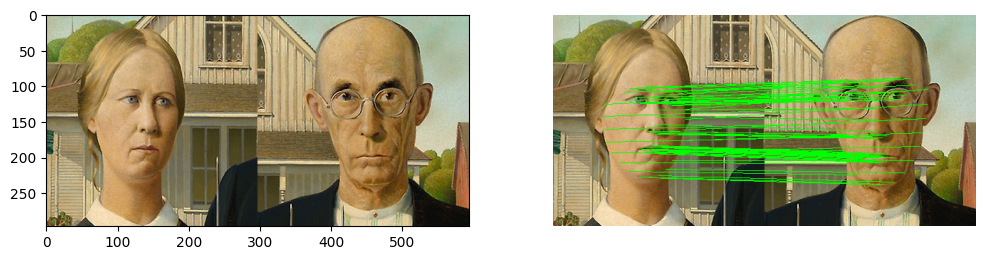

In [158]:
if len(source_coords) != len(target_coords):
    raise ValueError("Source and target images must have the same number of landmarks.")

# Create a new image for drawing lines
image_with_lines = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# Draw lines from each landmark in the source to the corresponding landmark in the target
for src_pt, tgt_pt in zip(source_coords, target_coords):
    # Convert points to tuples
    src_pt = tuple(src_pt)
    tgt_pt = tuple(tgt_pt)

    # Draw a line from source to target
    cv2.line(image_with_lines, src_pt, tgt_pt, (0, 255, 0), 1)

# Display the images
better_plotter([
    {
        "img": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "title": ""
    },
    {
        "img": image_with_lines,
        "title": ""
    }
], plot_size=(12, 6))

In [ ]:
# Create a mask with the same dimensions as the image, initialized to zero (black)
mask = np.zeros_like(image.copy())

# Convert the triangle to a format suitable for cv2.fillConvexPoly
triangle_ = np.array(
    # [target_triangles[0]], 
    [source_triangles[0]], 
    np.int32
)

# # Fill the triangle in the mask with white color
cv2.fillConvexPoly(mask, triangle_, (255, 255, 255))

# Apply the mask to the image: only the triangle area will be shown
masked_image = cv2.bitwise_and(image.copy(), mask)

# Display the images
better_plotter([
    {
        "img": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "title": ""  
    },
    {
        "img": cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB),
        "title": ""
    }
], plot_size=(12, 6))

---

## Warping

We want to warp all triangles to from source to the target, following this equation:

$$
\begin{bmatrix}
x_t \\ y_t
\end{bmatrix} = 
\begin{bmatrix}
a & b \\ c & d
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix} +
\begin{bmatrix}
t_x \\ t_y
\end{bmatrix}
$$

where:

- ($x$, $y$) is the source pixel location
- ($x_t$, $y_t$) is the target pixel location

variables available to use:

- `source_coords`: coordinates of each landmark points for the source face
- `source_triangles`: coordinates of each triangles for the source face
- `target_coords`: coordinates of each landmark points for the target face
- `target_triangles`: coordinates of each triangles for the target face

### Reference

- https://docs.opencv.org/4.x/d4/d61/tutorial_warp_affine.html

In [ ]:
'''
source_coords: coordinates of each landmark points for the source face
source_triangles: coordinates of each triangles for the source face
target_coords: coordinates of each landmark points for the target face
target_triangles: coordinates of each triangles for the target face
'''

In [159]:
# Define source and target triangles
source_triangles_warp = np.array(source_triangles, dtype=np.float32)
target_triangles_warp = np.array(target_triangles, dtype=np.float32)

# target_triangles_warp = [ [[x - face_offset, y] for x, y in triangle] for triangle in target_triangles_warp ]
if np.any(target_triangles_warp[:,:,0][:,0]>= face_offset):
    target_triangles_warp[:,:,0] -= face_offset
# print(target_triangles_warp[0])

print("source triangles")
for i in range(0, 3):
    print("previuos:", source_triangles[0][i], "\t", "after:", source_triangles_warp[0][i])
print()
print("target triangles")
for i in range(0, 3):
    print("previuos:", target_triangles_warp[0][i], "\t", "after:", target_triangles_warp[0][i])

print(image.shape[1])

source triangles
previuos: (72, 126) 	 after: [ 72. 126.]
previuos: (108, 120) 	 after: [108. 120.]
previuos: (71, 143) 	 after: [ 71. 143.]

target triangles
previuos: [ 91. 112.] 	 after: [ 91. 112.]
previuos: [113. 115.] 	 after: [113. 115.]
previuos: [ 93. 132.] 	 after: [ 93. 132.]
594


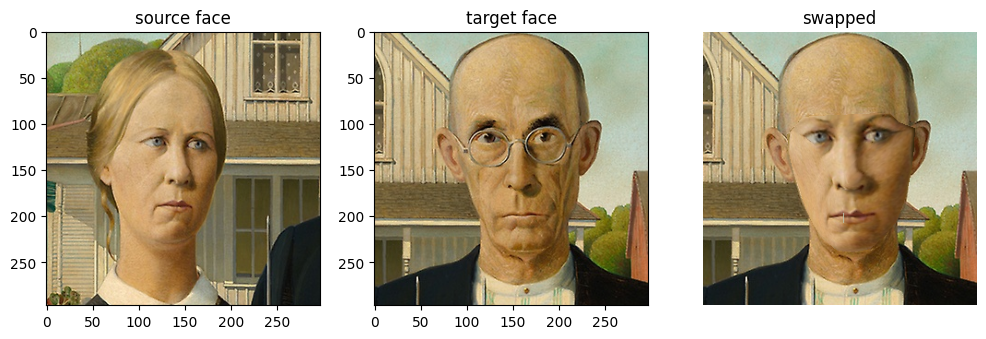

In [161]:
source_face_warp = source_face_resized.copy()
target_face_warp = target_face.copy()

# Loop through each triangle and perform the warp
for i in range(len(source_triangles)):
    # Get source and target triangle vertices
    src_triangle = source_triangles_warp[i]
    dst_triangle = target_triangles_warp[i]

    # print(src_triangle, dst_triangle)

    # Calculate affine transformation matrix
    M = cv2.getAffineTransform(src_triangle, dst_triangle)

    # Warp the source triangle to the target triangle
    warped_triangle = cv2.warpAffine(
        # target_face_warp, 
        source_face_warp, 
        M, 
        (target_face_warp.shape[1], target_face_warp.shape[0]), 
        borderMode=cv2.BORDER_REFLECT
    )

    # Mask the warped triangle and add it to the target image
    mask = np.zeros_like(target_face_warp, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_triangle), (1, 1, 1), 16, 0)
    
    target_face_warp = target_face_warp * (1 - mask) + warped_triangle * mask

# Display the images
better_plotter([
    {
        "img": source_face_warp,
        "title": "source face"
    },
    {
        "img": target_face.copy(),
        "title": "target face"
    },
    {
        "img": target_face_warp,
        "title": "swapped"
    }
], plot_size=(12, 4))